In [1]:
import ast

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

import graph_reinforcement_learning_using_blockchain_data as grl

2025-05-14 16:58:33.834 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:12 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


In [2]:
file_paths = [
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_1_train.csv",
    grl.PROCESSED_DATA_DIR / f"AIRL" / "airl_1_test.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_val.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_0_train.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_0_test.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings_dgi_128.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings_pre_trained_128.csv",
]

In [3]:
eth_data_dict = grl.load_dataframes(file_paths[:5])
embeddings_dict = grl.load_dataframes(file_paths[5:])

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/graph_reinforcement_learning_using_blockchain_data/utils.py:121: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes_dict[key] = pd.read_csv(path)


In [4]:
for k, df in embeddings_dict.items():
    df["embeddings"] = df["embeddings"].apply(
        lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
    )
    embeddings_dict[k] = df

In [5]:
data_dict = {}
for k, emb in embeddings_dict.items():
    data_dict.setdefault(k, {})
    for key, df in eth_data_dict.items():
        data_dict[k][key] = pd.merge(
            df, emb, how="inner", left_on="transaction_hash", right_on="transactionHash"
        )

In [6]:
trajectories = {}
for k, dicti in data_dict.items():
    trajectories[k] = grl.extract_trajectories(dicti)

In [7]:
venvs = {}
for k, df_dict in data_dict.items():
    grl.register_envs(df_dict)
    venvs[k] = grl.make_venvs(df_dict)

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/TransactionGraphEnv_airl_1_train_v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/TransactionGraphEnv_airl_1_test_v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/Transa

In [8]:
def download_reward_net(local_path: str) -> torch.nn.Module:
    local_path = mlflow.artifacts.download_artifacts(artifact_uri=local_path)
    reward_net = torch.load(local_path, weights_only=False)
    reward_net.eval()
    return reward_net

In [9]:
def calcualte_calibrated_rewards(
        reward_net0, reward_net1, alpha0, alpha1, beta0, beta1, test_trajectories
):
    states, obs, next_states, dones = (
        test_trajectories.obs,
        test_trajectories.acts,
        test_trajectories.next_obs,
        test_trajectories.dones,
    )
    with torch.no_grad():
        # For reward_net0
        rewards0 = reward_net0.predict(states, obs, next_states, dones)
        calibrated_rewards0 = alpha0 * rewards0 + beta0
        print("Reward network 0: ", calibrated_rewards0.mean())

        # For reward_net1
        rewards1 = reward_net1.predict(states, obs, next_states, dones)
        calibrated_rewards1 = alpha1 * rewards1 + beta1
        print("Reward network 1: ", calibrated_rewards1.mean())

    return calibrated_rewards0, calibrated_rewards1

In [10]:
def calc_stats(y_pred, y):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [11]:
def calc_overall_metrics(rewards0_traj_0, rewards1_traj_0, rewards1_traj0, rewards1_traj1):
    predictions_trajectories_0 = [
        0 if r0 > r1 else 1 for r0, r1 in zip(rewards0_traj_0, rewards1_traj_0)
    ]
    true_labels_0 = [0] * len(predictions_trajectories_0)

    predictions_trajectories_1 = [
        1 if r0 < r1 else 0 for r0, r1 in zip(rewards1_traj0, rewards1_traj1)
    ]
    true_labels_1 = [1] * len(predictions_trajectories_1)

    print(len(true_labels_0), len(true_labels_1))

    predictions = predictions_trajectories_0 + predictions_trajectories_1

    true_labels = true_labels_0 + true_labels_1

    calc_stats(predictions, true_labels)
    return true_labels, predictions

## Supervised AIRL Evaluation

In [12]:
airl_supervised_rn_0 = download_reward_net(
    "mlflow-artifacts:/282678262450638424/a4079fa13ff54f0ca0c39520807b2a28/artifacts/reward_net"
)
airl_supervised_rn_1 = download_reward_net(
    "mlflow-artifacts:/282678262450638424/bbbd66c8bf254d339f0c853918ea9428/artifacts/reward_net"
)
# airl_dgi_rn_0 = download_reward_net("mlflow-artifacts:/282678262450638424/a4079fa13ff54f0ca0c39520807b2a28/artifacts/reward_net")
# airl_dgi_rn_1 = download_reward_net("mlflow-artifacts:/282678262450638424/a4079fa13ff54f0ca0c39520807b2a28/artifacts/reward_net")


In [13]:
alpha_sup_0, beta_sup_0 = grl.calibrate(
    trajectories["state_embeddings"]["airl_val"], airl_supervised_rn_0
)
alpha_sup_1, beta_sup_1 = grl.calibrate(
    trajectories["state_embeddings"]["airl_val"], airl_supervised_rn_1
)
# alpha_dgi_0 = grl.calibrate(trajectories["state_embeddings_dgi_128"]["airl_val"], airl_dgi_rn_0)
# alpha_dgi_1 = grl.calibrate(trajectories["state_embeddings_dgi_128"]["airl_val"], airl_dgi_rn_1)


In [14]:
rewards_cal_sup0_traj_0, rewards_cal_sup1_traj_0 = calcualte_calibrated_rewards(
    airl_supervised_rn_0,
    airl_supervised_rn_1,
    alpha_sup_0,
    alpha_sup_1,
    beta_sup_0,
    beta_sup_1,
    trajectories["state_embeddings"]["airl_0_test"],
)
rewards_cal_sup0_traj_1, rewards_cal_sup1_traj_1 = calcualte_calibrated_rewards(
    airl_supervised_rn_0,
    airl_supervised_rn_1,
    alpha_sup_0,
    alpha_sup_1,
    beta_sup_0,
    beta_sup_1,
    trajectories["state_embeddings"]["airl_1_test"],
)

Reward network 0:  0.5482375
Reward network 1:  -0.3363152
Reward network 0:  -0.891144
Reward network 1:  0.45423397


In [15]:
true_labels, predictions = calc_overall_metrics(rewards_cal_sup0_traj_0, rewards_cal_sup1_traj_0, rewards_cal_sup0_traj_1, rewards_cal_sup1_traj_1)

4199 15595
Accuracy: 0.9304839850459735
Precision: 0.9258460616951183
Recall: 0.991151009939083
F1 Score: 0.9573861876742026


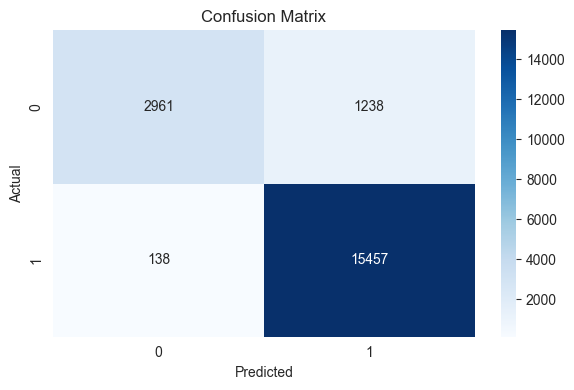

In [16]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()

## Semi-Supervised AIRL Evaluation

In [17]:
airl_semisup_rn_0 = download_reward_net(
    "mlflow-artifacts:/720343879195193287/c3122459182745a6931550125ca86cc7/artifacts/reward_net0v2"
)
airl_semisup_rn_1 = download_reward_net(
    "mlflow-artifacts:/720343879195193287/98b9c7da33354c88821f1eb65b123518/artifacts/reward_net1v2"
)

In [18]:
alpha_sem_0, beta_sem_0 = grl.calibrate(
    trajectories["state_embeddings_pre_trained_128"]["airl_val"], airl_semisup_rn_0
)
alpha_sem_1, beta_sem_1 = grl.calibrate(
    trajectories["state_embeddings_pre_trained_128"]["airl_val"], airl_semisup_rn_1
)

In [19]:
rewards_cal_sem0_traj_0, rewards_cal_sem1_traj_0 = calcualte_calibrated_rewards(
    airl_semisup_rn_0,
    airl_semisup_rn_1,
    alpha_sem_0,
    alpha_sem_1,
    beta_sem_0,
    beta_sem_1,
    trajectories["state_embeddings_pre_trained_128"]["airl_0_test"],
)
rewards_cal_sem0_traj_1, rewards_cal_sem1_traj_1 = calcualte_calibrated_rewards(
    airl_semisup_rn_0,
    airl_semisup_rn_1,
    alpha_sem_0,
    alpha_sem_1,
    beta_sem_0,
    beta_sem_1,
    trajectories["state_embeddings_pre_trained_128"]["airl_1_test"],
)

Reward network 0:  0.09410967
Reward network 1:  -0.70131683
Reward network 0:  -0.1630237
Reward network 1:  0.72405946


In [20]:
true_labels, predictions = calc_overall_metrics(rewards_cal_sem0_traj_0, rewards_cal_sem1_traj_0, rewards_cal_sem0_traj_1, rewards_cal_sem1_traj_1)

4199 15595
Accuracy: 0.9785793674850964
Precision: 0.9820169028404397
Recall: 0.9909586405899327
F1 Score: 0.986467509255713


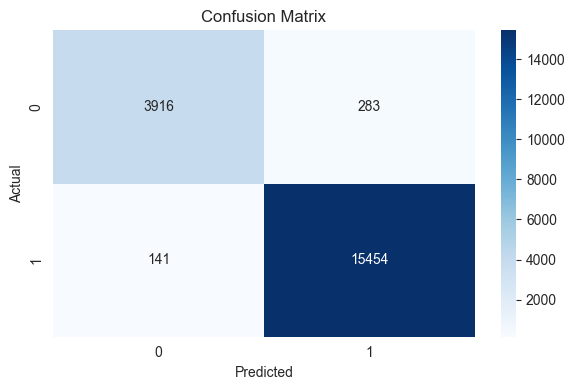

In [21]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()